# Import modules (google colab syntax !)

In [2]:
# !pip install lifelines
# !pip install sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
# from google.colab import drive
# Mount Google Drive
# drive.mount('/content/drive')

### Fetch data

In [3]:
# Load Data
train_data_path = 'data/train_data.csv'
test_data_path = 'data/test_data.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Preprocessing
X_train = train_data.drop(columns=['Label', 'DssTime','Event'])  # Include all features except target and event
y_train = train_data['Label']  # Target column

X_test = test_data.drop(columns=['Label', 'DssTime', 'Event'])  # Include all features except target and event
y_test = test_data['Label']  # Target column

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Define DeepSurv

In [4]:
# Define Custom Loss Function: Negative Partial Log Likelihood
def cox_ph_loss(event, log_hazard_ratio):
    """
    event: Binary censoring indicator (1 if event occurred, 0 if censored)
    log_hazard_ratio: Predicted log hazard ratios
    """
    hazard_ratio = tf.exp(log_hazard_ratio)
    log_cumulative_hazard = tf.math.log(tf.cumsum(hazard_ratio, axis=0, reverse=True))
    uncensored_likelihood = log_hazard_ratio - log_cumulative_hazard
    censored_likelihood = uncensored_likelihood * event
    return -tf.reduce_mean(censored_likelihood)

# Build the DeepSurv Model with Hyperparameters
class DeepSurv(tf.keras.Model):
    def __init__(self, input_dim, hidden_layers, learning_rate=1e-3,
                 dropout_rate=0.3, l1_reg=0.0, l2_reg=1e-4, batch_norm=False):
        """
        Parameters:
        - input_dim: Number of input features
        - hidden_layers: List of units in each hidden layer
        - learning_rate: Learning rate for training
        - dropout_rate: Dropout percentage after each hidden layer
        - l1_reg: L1 regularization coefficient
        - l2_reg: L2 regularization coefficient
        - batch_norm: Boolean, whether to use batch normalization
        """
        super(DeepSurv, self).__init__()
        self.hidden_layers = []
        for units in hidden_layers:
            self.hidden_layers.append(layers.Dense(
                units, activation='relu',
                kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)
            ))
            if batch_norm:
                self.hidden_layers.append(layers.BatchNormalization())
            self.hidden_layers.append(layers.Dropout(dropout_rate))
        self.output_layer = layers.Dense(1, activation=None)  # Log hazard ratio
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x, training=training)
        return self.output_layer(x)



# Set hyperparameters and train DeepSurv


In [5]:
# Initialize Model with Full Hyperparameter Control
# -------------------------------------------------
input_dim = X_train_scaled.shape[1]
hidden_layers = [128, 64, 32]  # Architecture
learning_rate = 1e-3
dropout_rate = 0.4
l1_reg = 1e-05
l2_reg = 0.0001
batch_norm = False

# Initialize DeepSurv model
deep_surv = DeepSurv(input_dim, hidden_layers, learning_rate, dropout_rate, l1_reg, l2_reg, batch_norm)

# Compile the model with Cox Proportional Hazards loss
deep_surv.compile(optimizer=deep_surv.optimizer, loss=cox_ph_loss)

# Train the model on the training data
deep_surv.fit(
    X_train_scaled,
    y_train,
    batch_size=32,
    epochs=50,
    verbose=1
)

# Define the time points for which we want survival probabilities
time_points = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]



Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4179
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3749 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3701 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4426 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4593 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3695 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4291 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3669 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.2711
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3630 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3235 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.4151
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2062 
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2476 
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3646 
E

# Calculate risk scores

In [6]:
# Predict Risk Scores for Training Data
risk_scores_train = deep_surv.predict(X_train_scaled).flatten()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [7]:
# Step 2: Compute and Simplify the Baseline Hazard Function
# ---------------------------------------------------------
# Sort data by survival times
# Align the predicted risk scores with the sorted survival times.
# Sorting ensures that the baseline hazard calculation respects the temporal order.
survival_times = train_data['DssTime']  # Use the correct survival time column
sorted_indices = np.argsort(survival_times)  # returns sorted indices of survival times
sorted_times = survival_times.iloc[sorted_indices]  # uses sorted indices to rearrange survival times
sorted_risks = np.exp(risk_scores_train[sorted_indices])  # convert the log risk scores into risk scores using the exponential function


### **Calculate the cumulative baseline hazard**
(represents the risk of an event happening over time for the baseline group)

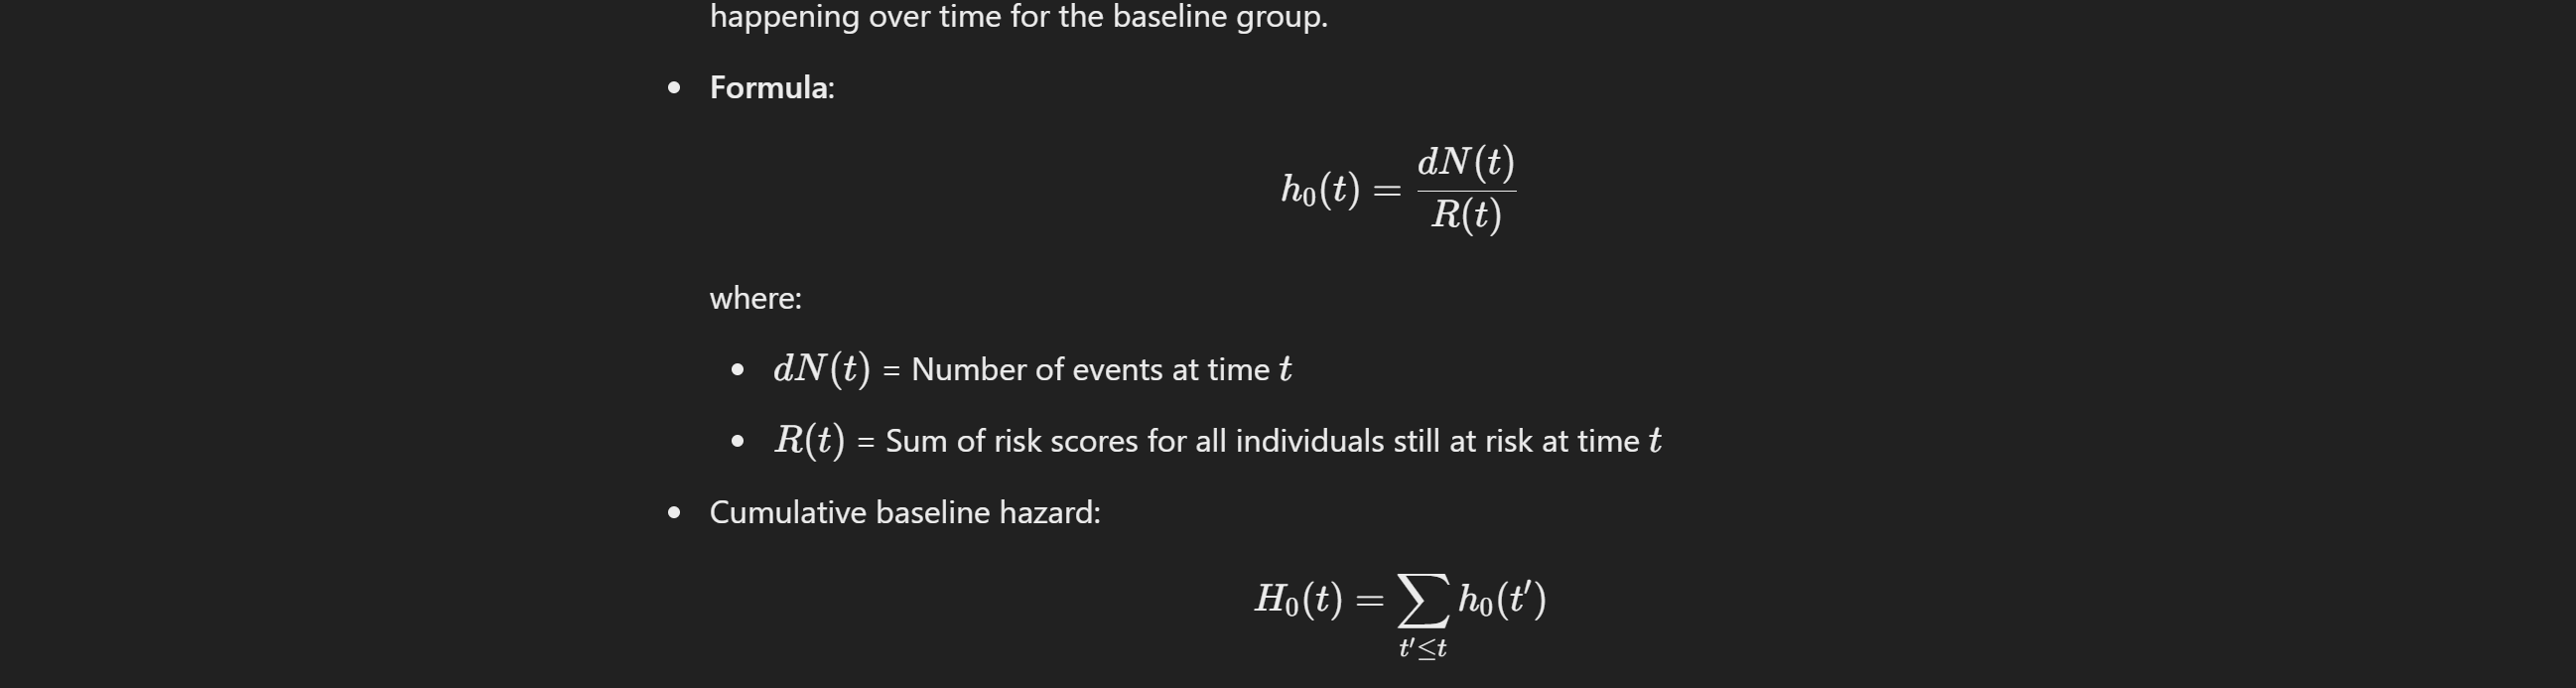


In [8]:
# Calculate Cumulative Baseline Hazard
unique_times, counts = np.unique(sorted_times, return_counts=True)  # Unique times and their counts of event for that time
cumulative_baseline_hazard = []
risk_sum = np.sum(sorted_risks)

for time, event_count in zip(unique_times, counts):
    hazard = event_count / risk_sum  # Events / At-risk in Formula dN(t)/R(t)
    if cumulative_baseline_hazard:
        cumulative_baseline_hazard.append(cumulative_baseline_hazard[-1] + hazard)  # Add to cumulative
    else:
        cumulative_baseline_hazard.append(hazard)  # First time point
    risk_sum -= np.sum(sorted_risks[sorted_times == time])  # Subtract patients who are no longer at risk

# Clip the cumulative baseline hazard to prevent extreme values
cumulative_baseline_hazard = np.clip(cumulative_baseline_hazard, 1e-6, None)


### Baseline Hazard Interpolation

In [9]:
# Estimate the cumulative baseline hazard for specific time points using interpolation.
# Interpolate baseline hazard for specified time points
baseline_hazards = np.interp(
    time_points,
    unique_times,
    cumulative_baseline_hazard,
    left=cumulative_baseline_hazard[0],
    right=cumulative_baseline_hazard[-1]
)


### Why Do We Interpolate?
Discreteness of Training Data:

The baseline hazard is calculated at specific survival times (e.g., [2, 5, 12, 25]) from the training data.
However, predictions might need survival probabilities at arbitrary time points (e.g., [1, 10, 20, 30]) not directly present in the training data.

Smoothness of the Survival Function:

Survival probabilities depend on the cumulative baseline hazard, which should be smoothly defined over time.
Interpolation ensures a continuous and meaningful estimate of the cumulative baseline hazard at any time, even between known survival times.
Flexibility in Time Predictions:

Interpolation allows the model to predict survival probabilities for any time point, regardless of whether that time point was observed in the training dataset.
For example, if the training data includes survival times [1, 5, 10] but you want to calculate survival at t=7, interpolation estimates the cumulative baseline hazard for t=7.
Consistency in Calculations:

Interpolation avoids gaps in the baseline hazard function by filling in values between observed time points. This ensures consistent behavior when computing survival probabilities.

## Calculate Survial Probability
[with Baseline Hazard and risk_factors (from the test data)]

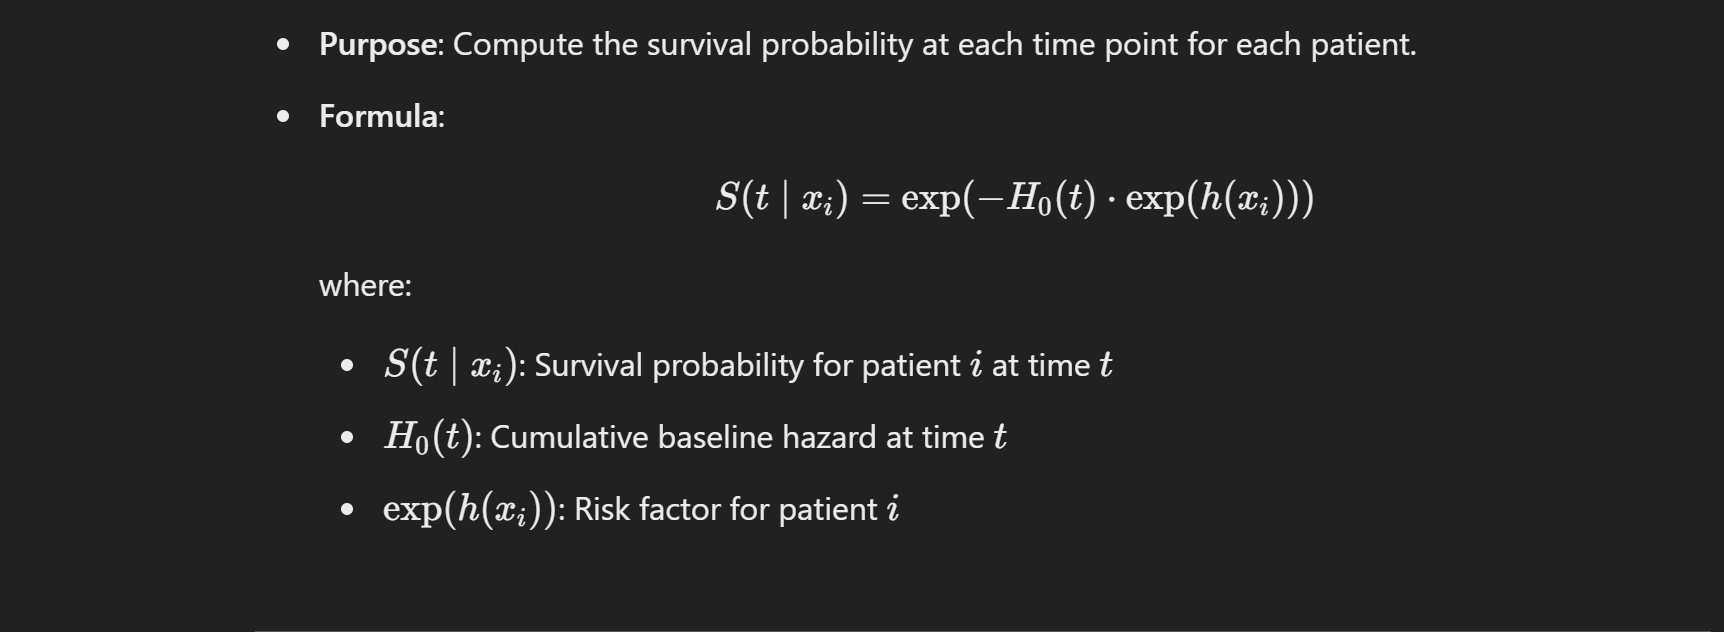

In [10]:
# Predict Risk Scores for Testing Data
risk_scores_test = deep_surv.predict(X_test_scaled).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [11]:
# Calculate survival probabilities
# Compute survival probabilities for all test patients
survival_probabilities = {}
for t, baseline_hazard in zip(time_points, baseline_hazards):
    # Correctly compute risk factors for each patient
    risk_factors = np.exp(risk_scores_test)
    risk_factors = np.clip(np.exp(risk_scores_test), 1e-3, 1e3)  # Adjust range to [1e-3, 1e3]
    survival_probabilities[t] = np.exp(-baseline_hazard * risk_factors)


#### **So what happened here ?**
We iterate through each pair of a specified time point (t) and its corresponding interpolated baseline hazard (baseline_hazard) and calculate the survival probability at each time point t. In other words, we apply the baseline hazards with the according time points t to all of the risk_scores.

### Extract the survival probability for t=60 and label the test data

In [12]:
# extract crucial survival time of 60 months
t60_probabilities_baseline = survival_probabilities[60]
# Predict labels based on threshold
optimal_threshold = 0.50  # Adjust threshold as necessary
# label test data
predicted_labels_t60_baseline = (t60_probabilities_baseline <= optimal_threshold).astype(int)

### Survival Model without baseline (actually irrelevant here lol)

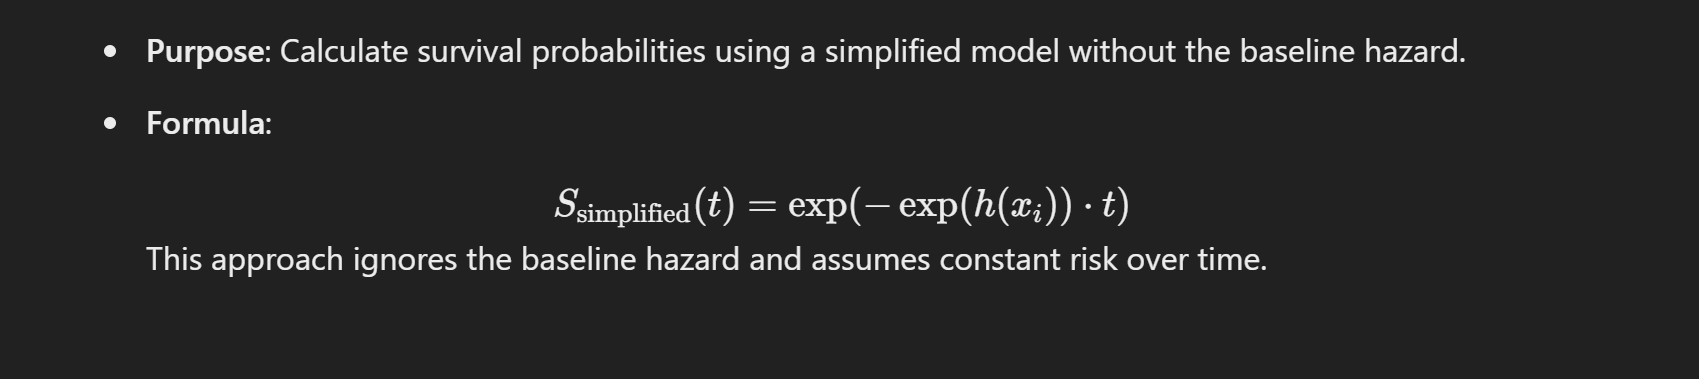

In [13]:
# This mimics a simpler model without a baseline hazard
time_point = 60  # Use t=60 for predictions
simplified_survival_probabilities = np.exp(-np.exp(risk_scores_test) * time_point)# * temporal_decay)
t60_probabilities_simplified = simplified_survival_probabilities
predicted_labels_t60_simplified = (t60_probabilities_simplified <= 0.000001).astype(int)


# Save predictions in a dataframe

In [15]:

# Save Predictions for All Time Points
# -------------------------------------
results = pd.DataFrame(survival_probabilities)
results['Predicted Label (Baseline, t=60)'] = predicted_labels_t60_baseline
results['Predicted Label (Simplified, t=60)'] = predicted_labels_t60_simplified
results['True Label'] = y_test
results_path = 'survival_predictions.csv'
results.to_csv(results_path, index=False)

# Evaluate model

In [16]:
# Evaluate Model for t=60
# ------------------------
accuracy_baseline = accuracy_score(y_test, predicted_labels_t60_baseline)
roc_auc_baseline = roc_auc_score(y_test, predicted_labels_t60_baseline)

accuracy_simplified = accuracy_score(y_test, predicted_labels_t60_simplified)
roc_auc_simplified = roc_auc_score(y_test, predicted_labels_t60_simplified)

print(f"Baseline Model - Accuracy (t=60): {accuracy_baseline:.2f}, ROC AUC: {roc_auc_baseline:.2f}")
print(f"Simplified Model - Accuracy (t=60): {accuracy_simplified:.2f}, ROC AUC: {roc_auc_simplified:.2f}")


# C-Index for Training Data
from lifelines.utils import concordance_index

# C-Index for Training Data
c_index_train = concordance_index(X_train["DssTime"], -risk_scores_train, event_observed=np.ones_like(y_train))
print(f"C-Index (Training): {c_index_train:.2f}")

# C-Index for Test Data
c_index_test = concordance_index(X_test["DssTime"], -risk_scores_test, event_observed=np.ones_like(y_test))
print(f"C-Index (Test): {c_index_test:.2f}")


Baseline Model - Accuracy (t=60): 0.73, ROC AUC: 0.71
Simplified Model - Accuracy (t=60): 0.56, ROC AUC: 0.53


KeyError: 'DssTime'

### Create a Survival Plot for a patient

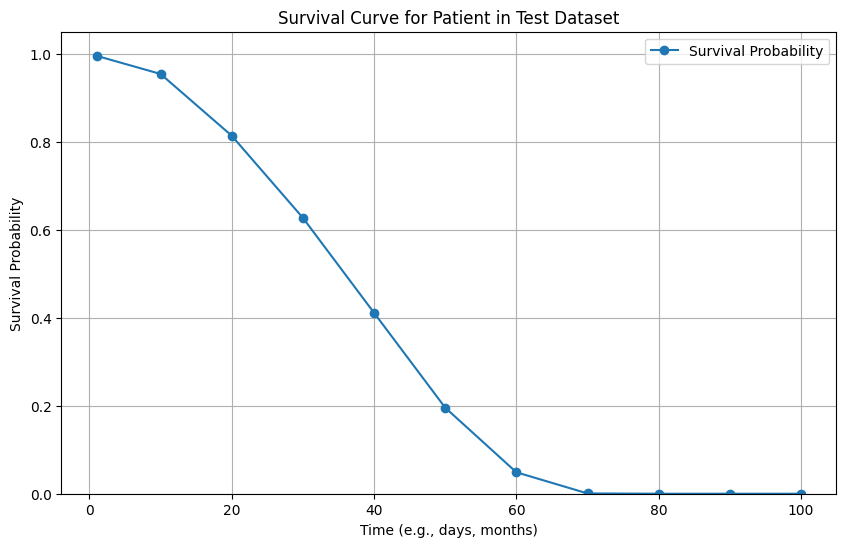


months:  1
survival probability:  0.99999535

months:  10
survival probability:  0.99995434

months:  20
survival probability:  0.9997999

months:  30
survival probability:  0.9995471

months:  40
survival probability:  0.99913764

months:  50
survival probability:  0.9984174

months:  60
survival probability:  0.9970716

months:  70
survival probability:  0.9928749

months:  80
survival probability:  0.9853505

months:  90
survival probability:  0.94563264

months:  100
survival probability:  0.83302844


In [33]:
# Extract survival probabilities for the 5th patient
import matplotlib.pyplot as plt
first_patient_probabilities = [survival_probabilities[t][0] for t in time_points]

# Plot the survival curve for the first patient
plt.figure(figsize=(10, 6))
plt.plot(time_points, first_patient_probabilities, marker='o', label="Survival Probability")
plt.title("Survival Curve for Patient in Test Dataset")
plt.xlabel("Time (e.g., days, months)")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)  # Ensure the y-axis is between 0 and 1
plt.grid(True)
plt.legend()
plt.show()

# patients survival scores
for i in time_points:
  print("")
  print("months: ",i)
  print("survival probability: ",survival_probabilities[i][1])